In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import sys
import torch as pt

sys.path.insert(0, '..')

from function_space import DenseNet, SingleParam
from problems import LLGC
from solver import Solver
from utilities import do_importance_sampling, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

In [ ]:
seed = 42

llgc = LLGC(d=20, T=1, seed=seed, off_diag=0.1)

K = 200
print_every = 1000
L = 8000
lr = 0.01
delta_t = 0.01
IS_K = 20000

models = [Solver(name='moment zero', problem=llgc, loss_method='moment', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, learn_Y_0=True),
             Solver(name='moment bad', problem=llgc, loss_method='moment', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, learn_Y_0=True),
             Solver(name='moment perfect', problem=llgc, loss_method='moment', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, learn_Y_0=True),
          Solver(name='log-variance', problem=llgc, loss_method='log-variance', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True)]

models[0].y_0 = SingleParam(lr=models[0].lr, initial=0.0).to(models[0].device)
models[1].y_0 = SingleParam(lr=models[1].lr, initial=10.0).to(models[1].device)
models[2].y_0 = SingleParam(lr=models[2].lr, initial=llgc.v_true(pt.zeros(models[0].d), 0).item()).to(models[2].device)

#models[0].Y_0 = pt.tensor([0.0])
#models[1].Y_0 = pt.tensor([10.0])
#models[2].Y_0 = pt.tensor([llgc.v_true(pt.zeros(models[0].d), 0).item()])

for model in models:
    model.z_n.optim = pt.optim.SGD(model.z_n.parameters(), lr=model.lr)
    model.update_Phis()
    model.train()

In [55]:
#save_exp_logs(models, 'paper/LLGC_d20_different_Y_0_adam')

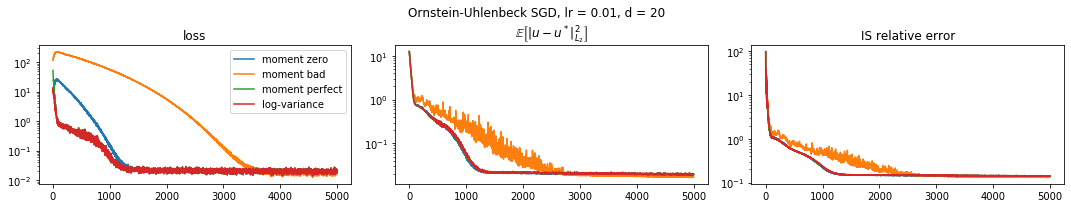

In [65]:
fig = plot_loss_logs('Ornstein-Uhlenbeck SGD, lr = 0.01', models)

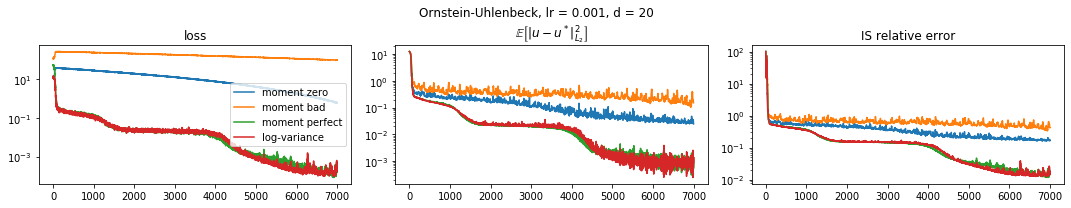

In [60]:
fig = plot_loss_logs('Ornstein-Uhlenbeck Adam, lr = 0.001', models)

## Plots for the paper

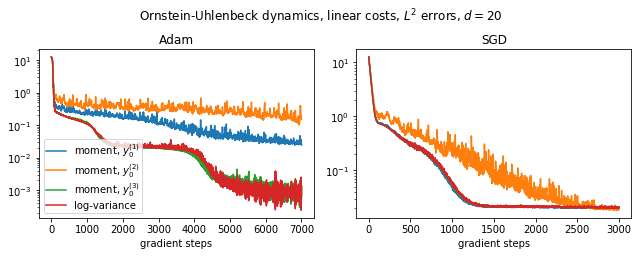

In [7]:
exp_logs_adam = load_exp_logs('paper/LLGC_d20_different_Y_0_adam_2020-04-18.json')
exp_logs_SGD = load_exp_logs('paper/LLGC_d20_different_Y_0_SGD_2020-04-21.json')

fig, ax = plt.subplots(1, 2, figsize=(9, 3.7))
fig.suptitle(r'Ornstein-Uhlenbeck dynamics, linear costs, $L^2$ errors, $d = 20$')

ax[0].plot(exp_logs_adam['moment zero']['u_L2_loss'], label=r'moment, $y_0^{(1)}$')
ax[0].plot(exp_logs_adam['moment bad']['u_L2_loss'], label=r'moment, $y_0^{(2)}$')
ax[0].plot(exp_logs_adam['moment perfect']['u_L2_loss'], label=r'moment, $y_0^{(3)}$')
ax[0].plot(exp_logs_adam['log-variance']['u_L2_loss'], label=r'log-variance')

for model_name in exp_logs_adam:
    ax[1].plot(exp_logs_SGD[model_name]['u_L2_loss'][:5000])
ax[0].set_yscale('log')
ax[0].set_title('Adam')
ax[1].set_yscale('log')
ax[1].set_title('SGD')
ax[0].legend(labelspacing=0.2, borderpad=0.2)
ax[0].set_xlabel('gradient steps')
ax[1].set_xlabel('gradient steps')

fig.tight_layout(rect=[0, 0.03, 1, 0.92])
#fig.savefig('img/LLGC_moment_different_Y_0_adam_SGD.pdf')